In [1]:
import pandas as pd
import json
import numpy as np

In [2]:
# Load a text file from disk and loop over it line by line and call json.loads() on each line to convert it into a Python dictionary
def load_json_to_dict(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

In [3]:
movies_df = pd.DataFrame(load_json_to_dict('tmdb/tmdb_movie_ids_04_28_2023.json')).set_index('id').sort_values('popularity',ascending=False)
movies_df = movies_df.sort_values('popularity',ascending=False)
movies_df

,adult,original_title,popularity,video
id,,,,
640146,False,Ant-Man and the Wasp: Quantumania,8567.865,False
502356,False,The Super Mario Bros. Movie,6572.614,False
594767,False,Shazam! Fury of the Gods,4274.232,False
76600,False,Avatar: The Way of Water,3365.913,False
948713,False,The Last Kingdom: Seven Kings Must Die,3119.049,False
...,...,...,...,...
1119098,False,Ichi-go-ichi-e: First and Last Time,0.000,False
1119099,False,Raghavendra Stores,0.000,False
1119101,False,STANDOFF.,0.000,False


In [4]:
movies_df.dtypes

adult                bool
original_title     object
popularity        float64
video                bool
dtype: object

In [5]:
# List movies with non-ascii (likely non-English) titles
movies_df[~movies_df['original_title'].apply(lambda x: x.isascii())]

,adult,original_title,popularity,video
id,,,,
1008005,False,La niña de la comunión,1154.300,False
849869,False,길복순,958.517,False
876792,False,劇場版 転生したらスライムだった件 紅蓮の絆編,581.249,False
1073413,False,Fenómenas,421.706,False
1071806,False,คนหิว เกมกระหาย,410.982,False
...,...,...,...,...
1119081,False,Viciados Anônimos,0.000,False
1119089,False,Endlich Witwer - Über alle Berge,0.000,False
1119090,False,Frankelda y el Príncipe de los Sustos,0.000,False


In [6]:
# Filter out movies (original_title) that are not in English based on their character set
movies_anglic_df = movies_df[movies_df['original_title'].apply(lambda x: x.isascii())]
movies_anglic_df

,adult,original_title,popularity,video
id,,,,
640146,False,Ant-Man and the Wasp: Quantumania,8567.865,False
502356,False,The Super Mario Bros. Movie,6572.614,False
594767,False,Shazam! Fury of the Gods,4274.232,False
76600,False,Avatar: The Way of Water,3365.913,False
948713,False,The Last Kingdom: Seven Kings Must Die,3119.049,False
...,...,...,...,...
1119098,False,Ichi-go-ichi-e: First and Last Time,0.000,False
1119099,False,Raghavendra Stores,0.000,False
1119101,False,STANDOFF.,0.000,False


In [7]:
# Keep top 10k movies based on popularity
movies_top10k_df = movies_anglic_df.iloc[0:10000]
movies_top10k_df

,adult,original_title,popularity,video
id,,,,
640146,False,Ant-Man and the Wasp: Quantumania,8567.865,False
502356,False,The Super Mario Bros. Movie,6572.614,False
594767,False,Shazam! Fury of the Gods,4274.232,False
76600,False,Avatar: The Way of Water,3365.913,False
948713,False,The Last Kingdom: Seven Kings Must Die,3119.049,False
...,...,...,...,...
563710,False,Angela's Christmas,10.753,False
345923,False,All I See Is You,10.753,False
10729,False,Quick Change,10.752,False


In [8]:
import seaborn as sns

/var/folders/4k/9rqmps197lzg1p4s1tln61000000gn/T/ipykernel_89221/1134606292.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(movies_top10k_df['popularity'], kde=False, rug=False, hist_kws={'log':True})
/Users/mdrk/miniconda3/envs/python311/lib/python3.11/site-packages/seaborn/distributions.py:2502: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.hist(a, bins, orientation=orientation,


<Axes: xlabel='popularity'>

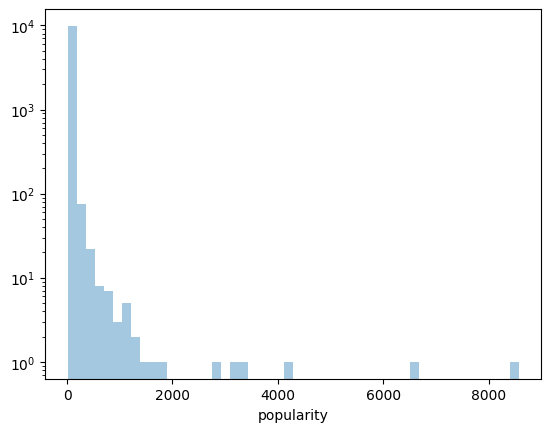

In [9]:
# Plot the distribution of the popularity score with the X axis on a log scale
sns.distplot(movies_top10k_df['popularity'], kde=False, rug=False, hist_kws={'log':True})

## Retrieving the metadata for the top-10K movies

In order to retrieve the full synopsis and metadata, such as the IMDB ID, we are going to have to query the TMDB API 10,000 times and store the results. Storing the results, beyond for transient purposes, is against their terms of service. We are *not* going to store, or use this data, for any other purpose than to scrape data from other sites and to compute embeddings. TMDB is an amazing public resource, available for free for non-commercial applications, so we are going to honor their TOS.


In [10]:
import asyncio
import aiohttp
import json
from fake_useragent import UserAgent
import random
import os

In [11]:
API_KEY = "YOUR_API_KEY"
MOVIE_IDS = movies_top10k_df.index.tolist()  # Replace with your list of movie IDs

In [74]:
# Function to fetch the movie data for a given TMDB movie ID
async def fetch_movie(session, movie_id):
    # Construct the URL for the movie using the movie ID and API Key
    url = f"https://api.themoviedb.org/3/movie/{movie_id}?api_key={API_KEY}"
    
    # Generate a random user agent for the request header
    # We do this to simulate different users making the requests and to avoid rate limiting
    # See https://developers.themoviedb.org/3/getting-started/request-rate-limiting
    headers = {"User-Agent": UserAgent().random}

    # Make an asynchronous GET request to fetch the movie data
    # If we receive a response with a status code of 200 (OK), return the JSON data
    # Otherwise, print an error message and return None
    async with session.get(url, headers=headers) as response:
        if response.status == 200:
            # If the request is successful, get the JSON data
            movie_data = await response.json()
            return movie_data
        else:
            print(f"Error fetching movie with ID {movie_id}: {response.status}")
            return None

# Function to fetch and store the movie data for a given movie ID
async def fetch_and_store_movie(movie_id):
    # Check if the file already exists
    file_path = f"movie_{movie_id}.json"
    # If the file already exists, print a message and return True
    # This is to avoid making unnecessary API calls and to speed up the process
    if os.path.exists(file_path):
        print(f"File for movie ID {movie_id} already exists. Skipping...")
        # Return True if the file already exists
        return True

    # Create an aiohttp client session for fetching the movie data
    async with aiohttp.ClientSession() as session:
        movie_data = await fetch_movie(session, movie_id)
        if movie_data:
            # Store the movie data as a JSON file
            with open(file_path, "w") as file:
                json.dump(movie_data, file)
            print(f"Stored movie data for ID {movie_id}")
        else:
            # If movie_data is None, add movie_id to the list of failed_movie_ids
            failed_movie_ids.append(movie_id)

    # Return False if the file did not exist and the movie data was fetched
    return False

# Main function to control the execution flow
async def main():
    # Define rate limit, delay between calls, and random delay variance
    rate_limit = 3
    delay_between_calls = 1 / rate_limit
    random_delay_variance = 0.1

    # Loop through the list of movie IDs
    for movie_id in MOVIE_IDS:
        # Call fetch_and_store_movie and get the result indicating if the file already exists
        file_exists = await fetch_and_store_movie(movie_id)
        
        # Only wait for the next API call if the file does not exist
        if not file_exists:
            await asyncio.sleep(delay_between_calls + random.uniform(-random_delay_variance, random_delay_variance))

    # Print the list of failed movie IDs
    print("Failed to fetch the following movie IDs:", failed_movie_ids)

# Initialize the list of failed movie IDs outside the main function
failed_movie_ids = []

In [ ]:
# Depending on how successful you are. You may need to run this multiple times to get all the data.
# Since we skip existing files, we can run this multiple times without worrying about overwriting existing data and
# it will run faster each time since we will have already fetched the data for some movies
await main()

In [76]:
failed_movie_ids

[]

In [12]:
import glob

In [14]:
# Load a text file from disk and loop over it line by line and call json.loads() on each line to convert it into a Python dictionary
def load_json_files_to_dict(file_paths):
    data = []
    for path in file_paths:
        with open(path, 'r') as f:
            data.append(json.loads(f.read()))
    return data

In [15]:
movies_top10k_complete_df = pd.DataFrame(load_json_files_to_dict(glob.glob("movie_*.json"))).set_index('id').loc[movies_top10k_df.index]
movies_top10k_complete_df

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
id,,,,,,,,,,,,,,,,,,,,,
640146,False,/gMJngTNfaqCSCqGD4y8lVMZXKDn.jpg,"{'id': 422834, 'name': 'Ant-Man Collection', '...",200000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",https://www.marvel.com/movies/ant-man-and-the-...,tt10954600,en,Ant-Man and the Wasp: Quantumania,Super-Hero partners Scott Lang and Hope van Dy...,...,2023-02-15,473237851,125,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Witness the beginning of a new dynasty.,Ant-Man and the Wasp: Quantumania,False,6.524,1906
502356,False,/iJQIbOPm81fPEGKt5BPuZmfnA54.jpg,None,100000000,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",https://www.thesupermariobros.movie,tt6718170,en,The Super Mario Bros. Movie,"While working underground to fix a water main,...",...,2023-04-05,891438061,92,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,The Super Mario Bros. Movie,False,7.517,1483
594767,False,/wybmSmviUXxlBmX44gtpow5Y9TB.jpg,"{'id': 724848, 'name': 'Shazam! Collection', '...",125000000,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",,tt10151854,en,Shazam! Fury of the Gods,"Billy Batson and his foster siblings, who tran...",...,2023-03-15,132128334,130,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Oh. My. Gods.,Shazam! Fury of the Gods,False,6.860,1253
76600,False,/ovM06PdF3M8wvKb06i4sjW3xoww.jpg,"{'id': 87096, 'name': 'Avatar Collection', 'po...",350000000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",https://www.avatar.com/movies/avatar-the-way-o...,tt1630029,en,Avatar: The Way of Water,Set more than a decade after the events of the...,...,2022-12-14,2312335665,192,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Return to Pandora.,Avatar: The Way of Water,False,7.720,7556
948713,False,/xwA90BwZXTh8ke3CVsQlj8EOkFr.jpg,None,0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",https://www.netflix.com/title/81460361,tt15767808,en,The Last Kingdom: Seven Kings Must Die,"In the wake of King Edward's death, Uhtred of ...",...,2023-04-14,0,111,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,The Last Kingdom: Seven Kings Must Die,False,7.382,234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563710,False,/8uj9vrZtZHJKIyYEKH6DuU0B6Sr.jpg,"{'id': 766198, 'name': 'Angela's Christmas Col...",0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",,tt7829544,en,Angela's Christmas,A trip to church with her family on Christmas ...,...,2017-12-02,0,30,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,Angela's Christmas,False,6.831,201
345923,False,/daBjwNXK5eZ0BYU9IAUcG7j5SJF.jpg,None,30000000,"[{'id': 9648, 'name': 'Mystery'}, {'id': 53, '...",http://www.alliseeisyoumovie.com/,tt4486986,en,All I See Is You,A blind woman's relationship with her husband ...,...,2017-08-10,646946,110,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,An obsessive love story.,All I See Is You,False,5.154,521
10729,False,/xd7GlVVQ53P53LN9bD6yHiF52cA.jpg,None,15000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 80, 'nam...",https://www.warnerbros.com/movies/quick-change/,tt0100449,en,Quick Change,"With the aid of his girlfriend, Phyllis Potter...",...,1990-07-13,15260154,89,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The bank robbery was easy. But getting out of ...,Quick Change,False,6.701,299


In [91]:
!pip3 install -U asyncio aiohttp beautifulsoup4 fake-useragent readability-lxml

  Preparing metadata (setup.py) ... done
  Created wheel for readability: filename=readability-0.3.1-py3-none-any.whl size=35459 sha256=418b43b38aa0ae8c5f1f48cc7f86425f8946ab19b71216de9437f863ede2cdb5
  Stored in directory: /Users/mdrk/Library/Caches/pip/wheels/2d/07/52/367d712825cfe4a19d6e9210fa3d3ea28fe57bdb1fd5616f5c
Successfully built readability


## Retrieving synopsis and plot summaries from IMDB

Using the metadata we just collected 

In [19]:
# Import necessary libraries
import asyncio
import aiohttp
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
import random
from readability import Document

# Replace with your list of IMDb IDs
IMDB_IDS = movies_top10k_complete_df.imdb_id.to_list()

# Function to fetch the IMDb page for a given IMDb ID
async def fetch_imdb_page(session, imdb_id):
    # Construct the URL for the IMDb page using the IMDb ID
    url = f'https://www.imdb.com/title/{imdb_id}/plotsummary'
    
    # Generate a random user agent for the request header
    headers = {'User-Agent': UserAgent().random}

    # Make an asynchronous GET request to fetch the IMDb page
    async with session.get(url, headers=headers) as response:
        if response.status == 200:
            # If the request is successful, get the HTML content
            html_content = await response.text()
            return html_content
        else:
            print(f'Error fetching IMDb page for ID {imdb_id}: {response.status}')
            return None

# Function to fetch and store the synopsis for a given IMDb ID
async def fetch_and_store_synopsis(imdb_id):
    # Create an aiohttp client session for fetching the IMDb page
    async with aiohttp.ClientSession() as session:
        html_content = await fetch_imdb_page(session, imdb_id)
        if html_content:
            # Parse the HTML content using BeautifulSoup
            soup = BeautifulSoup(html_content, 'lxml')
            
            # Use the readability module to extract a readable version of the synopsis
            readable_article = Document(soup.prettify()).summary()
            soup_readable_article = BeautifulSoup(readable_article, 'lxml')

            # Store the synopsis (e.g., save to an HTML file)
            with open(f'synopsis_{imdb_id}.html', 'w') as file:
                file.write(soup_readable_article.prettify())
            print(f'Stored synopsis for IMDb ID {imdb_id}')

# Main function to control the execution flow
async def main():
    # Define rate limit, delay between calls, and random delay variance
    rate_limit = 3
    delay_between_calls = 1 / rate_limit
    random_delay_variance = 0.1

    # Loop through the list of IMDb IDs
    for imdb_id in IMDB_IDS:
        # Call fetch_and_store_synopsis for each IMDb ID
        await fetch_and_store_synopsis(imdb_id)
        
        # Wait for a random duration before making the next API call
        await asyncio.sleep(delay_between_calls + random.uniform(-random_delay_variance, random_delay_variance))

In [ ]:
# Depending on how successful you are. You may need to run this multiple times to get all the data.
# Since we skip existing files, we can run this multiple times without worrying about overwriting existing data and
# it will run faster each time since we will have already fetched the data for some movies
# Runetime is about 200 minutes
await main()

In [21]:
synopsis_docs = glob.glob("synopsis_*.html")
len(synopsis_docs)

9797

In [26]:
import re
from bs4 import BeautifulSoup

def extract_plain_text_from_html(file_path):
    with open(file_path, 'r') as file:
        html_content = file.read()

    soup = BeautifulSoup(html_content, 'lxml')

    # Replace <p> tags with new lines
    for p_tag in soup.find_all('p'):
        p_tag.replace_with(f'\n{p_tag.text}')

    # Extract plain text from the modified soup
    plain_text = soup.get_text()

    # Remove any remaining tags within angle brackets
    plain_text = re.sub('<[^>]*>', '', plain_text)

    # Replace multiple newlines and whitespace with a single newline
    plain_text = re.sub('\n\s*\n', '\n', plain_text).strip()

    # Replace multiple spaces with a single space
    plain_text = re.sub(' +', ' ', plain_text)

    return plain_text

In [31]:
imdb_synopsis = pd.DataFrame({'text': [extract_plain_text_from_html(s) for s in synopsis_docs]}, index=[s.replace('synopsis_', '').replace('.html', '') for s in synopsis_docs])
imdb_synopsis['characters'] = imdb_synopsis.text.str.len()
imdb_synopsis

,text,characters
tt0372237,Percy and Marilyn are renewing their vows for ...,699
tt0211181,Reformed and recently released from prison aft...,756
tt2418558,Gwendolyn Shepherd is a regular 16-year-old gi...,952
tt5078204,A bachelor enjoys his sweet life on the French...,193
tt7531096,A loyal dog and a vigilante cat embark on a sp...,84
...,...,...
tt3612032,"Two bikers, Daria and Nick, ride their bikes d...",1985
tt5638642,"Five old friends from university--Phil, Dom, H...",7329
tt5164214,The film starts with Debbie Ocean (Sandra Bull...,7444
tt0469111,"In a small Colorado town, Amber Williams (Broo...",4315


In [32]:
imdb_synopsis.sort_values('characters', ascending=False)

,text,characters
tt0144084,A white background. Red drops begin to fall pa...,64012
tt1345836,Commissioner James Gordon (\n Gary Oldman\n ) ...,59883
tt0399201,The Island begins with a montage of dream scen...,59251
tt0103064,Scenes described in red text appear only in th...,58761
tt0120912,The Columbia torch buzzes then flashes like a ...,57236
...,...,...
tt9224104,Plot unknown. Sequel to the 2018 film 'The Meg'.,48
tt9663764,Plot unknown. Sequel to the 2018 film 'Aquaman.',48
tt21983602,Lisa is convinced to become a Disney princess.,46
tt10160976,Sequel to the 2018 hit film --- The Nun.,40


In [33]:
# Split imdb_synopsis.text into chunks of 1000 characters
imdb_synopsis['chunks'] = imdb_synopsis.text.str.replace('\n', '').str.replace(' ', '').str.len() // 1000 + 1

<Axes: >

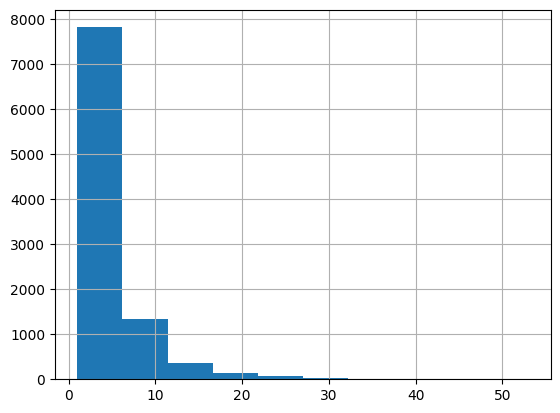

In [35]:
# Plot the distribution of number of chunks with a granularity of 1
imdb_synopsis.chunks.value_counts().sort_index().plot.bar()

In [36]:
(imdb_synopsis.chunks<=1).sum()

4389

In [47]:
imdb_synopsis.index.duplicated().sum()

0

In [50]:
movies_top10k_complete_df[~movies_top10k_complete_df.imdb_id.duplicated()]

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
id,,,,,,,,,,,,,,,,,,,,,
640146,False,/gMJngTNfaqCSCqGD4y8lVMZXKDn.jpg,"{'id': 422834, 'name': 'Ant-Man Collection', '...",200000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",https://www.marvel.com/movies/ant-man-and-the-...,tt10954600,en,Ant-Man and the Wasp: Quantumania,Super-Hero partners Scott Lang and Hope van Dy...,...,2023-02-15,473237851,125,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Witness the beginning of a new dynasty.,Ant-Man and the Wasp: Quantumania,False,6.524,1906
502356,False,/iJQIbOPm81fPEGKt5BPuZmfnA54.jpg,None,100000000,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",https://www.thesupermariobros.movie,tt6718170,en,The Super Mario Bros. Movie,"While working underground to fix a water main,...",...,2023-04-05,891438061,92,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,The Super Mario Bros. Movie,False,7.517,1483
594767,False,/wybmSmviUXxlBmX44gtpow5Y9TB.jpg,"{'id': 724848, 'name': 'Shazam! Collection', '...",125000000,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",,tt10151854,en,Shazam! Fury of the Gods,"Billy Batson and his foster siblings, who tran...",...,2023-03-15,132128334,130,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Oh. My. Gods.,Shazam! Fury of the Gods,False,6.860,1253
76600,False,/ovM06PdF3M8wvKb06i4sjW3xoww.jpg,"{'id': 87096, 'name': 'Avatar Collection', 'po...",350000000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",https://www.avatar.com/movies/avatar-the-way-o...,tt1630029,en,Avatar: The Way of Water,Set more than a decade after the events of the...,...,2022-12-14,2312335665,192,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Return to Pandora.,Avatar: The Way of Water,False,7.720,7556
948713,False,/xwA90BwZXTh8ke3CVsQlj8EOkFr.jpg,None,0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",https://www.netflix.com/title/81460361,tt15767808,en,The Last Kingdom: Seven Kings Must Die,"In the wake of King Edward's death, Uhtred of ...",...,2023-04-14,0,111,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,The Last Kingdom: Seven Kings Must Die,False,7.382,234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563710,False,/8uj9vrZtZHJKIyYEKH6DuU0B6Sr.jpg,"{'id': 766198, 'name': 'Angela's Christmas Col...",0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",,tt7829544,en,Angela's Christmas,A trip to church with her family on Christmas ...,...,2017-12-02,0,30,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,Angela's Christmas,False,6.831,201
345923,False,/daBjwNXK5eZ0BYU9IAUcG7j5SJF.jpg,None,30000000,"[{'id': 9648, 'name': 'Mystery'}, {'id': 53, '...",http://www.alliseeisyoumovie.com/,tt4486986,en,All I See Is You,A blind woman's relationship with her husband ...,...,2017-08-10,646946,110,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,An obsessive love story.,All I See Is You,False,5.154,521
10729,False,/xd7GlVVQ53P53LN9bD6yHiF52cA.jpg,None,15000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 80, 'nam...",https://www.warnerbros.com/movies/quick-change/,tt0100449,en,Quick Change,"With the aid of his girlfriend, Phyllis Potter...",...,1990-07-13,15260154,89,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The bank robbery was easy. But getting out of ...,Quick Change,False,6.701,299


In [54]:
# Do an outer join on the two dataframes based on the imdb_id data
movies_top10k_imdb_df = pd.concat([imdb_synopsis, movies_top10k_complete_df[~movies_top10k_complete_df.imdb_id.duplicated()].reset_index(drop=False).set_index('imdb_id')],axis=1)
movies_top10k_imdb_df = movies_top10k_imdb_df.sort_values('popularity', ascending=False)
movies_top10k_imdb_df

,text,characters,chunks,id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
tt10954600,During her days of entrapment in the Quantum R...,3025.0,3.0,640146,False,/gMJngTNfaqCSCqGD4y8lVMZXKDn.jpg,"{'id': 422834, 'name': 'Ant-Man Collection', '...",200000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",https://www.marvel.com/movies/ant-man-and-the-...,...,2023-02-15,473237851,125,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Witness the beginning of a new dynasty.,Ant-Man and the Wasp: Quantumania,False,6.524,1906
tt6718170,Italian-American brothers Mario and Luigi have...,2688.0,3.0,502356,False,/iJQIbOPm81fPEGKt5BPuZmfnA54.jpg,None,100000000,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",https://www.thesupermariobros.movie,...,2023-04-05,891438061,92,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,The Super Mario Bros. Movie,False,7.517,1483
tt10151854,"Several years after the defeat of Dr. Sivana, ...",14364.0,12.0,594767,False,/wybmSmviUXxlBmX44gtpow5Y9TB.jpg,"{'id': 724848, 'name': 'Shazam! Collection', '...",125000000,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",,...,2023-03-15,132128334,130,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Oh. My. Gods.,Shazam! Fury of the Gods,False,6.860,1253
tt1630029,Over a decade after the events of the first fi...,7104.0,6.0,76600,False,/ovM06PdF3M8wvKb06i4sjW3xoww.jpg,"{'id': 87096, 'name': 'Avatar Collection', 'po...",350000000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",https://www.avatar.com/movies/avatar-the-way-o...,...,2022-12-14,2312335665,192,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Return to Pandora.,Avatar: The Way of Water,False,7.720,7556
tt15767808,"Anlaf, a Viking king from Ireland, arrives wit...",4375.0,4.0,948713,False,/xwA90BwZXTh8ke3CVsQlj8EOkFr.jpg,None,0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",https://www.netflix.com/title/81460361,...,2023-04-14,0,111,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,The Last Kingdom: Seven Kings Must Die,False,7.382,234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt0048554,A tributary of the upper Amazon. A small boat ...,9088.0,8.0,40761,False,/uqnsM7TlWDBVeJyHKUSUfNkxuZm.jpg,"{'id': 221537, 'name': 'Creature From The Blac...",0,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",,...,1955-05-13,1100000,82,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,All New Thrills! Shocks! Suspense!,Revenge of the Creature,False,5.800,112
tt4400994,When cowboy Lefty Brown witnesses the murder o...,828.0,1.0,438457,False,/1BNnnrwOPRAJER3tzAKU659cpYY.jpg,None,8000000,"[{'id': 37, 'name': 'Western'}]",http://leftybrownmovie.com,...,2017-12-15,7856,105,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,He never wanted to be the hero,The Ballad of Lefty Brown,False,6.313,155
tt0091647,French anthropologist Jean Charles Pommier die...,3304.0,3.0,26725,False,/f0aKdbxNRcUX4YrTSN3s06w8fMz.jpg,None,2278264,"[{'id': 18, 'name': 'Drama'}, {'id': 14, 'name...",,...,1986-03-07,0,89,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,A terrifying story of the supernatural,Nomads,False,4.900,89
tt0066412,"Newly married to an older man, Julie returns t...",608.0,1.0,30903,False,/h6jNheRQAdwnJ2i3w6qQMYu3Lh2.jpg,None,0,"[{'id': 27, 'name': 'Horror'}, {'id': 80, 'nam...",,...,1971-01-15,0,98,"[{'english_name': 'Spanish', 'iso_639_1': 'es'...",Released,Always unheard… unseen… until he reached out t...,The Strange Vice of Mrs Wardh,False,6.827,127


## Scrape the 'Plot' section from Wikipedia

In [65]:
!pip3 install Wikipedia-API wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11680 sha256=d6aca6d8076b275ccddda8b48323d02c8cc857f0ae8de976af7adecc8e1b6245
  Stored in directory: /Users/mdrk/Library/Caches/pip/wheels/8f/ab/cb/45ccc40522d3a1c41e1d2ad53b8f33a62f394011ec38cd71c6
Successfully built wikipedia


In [144]:
import wikipediaapi

def get_wikipedia_movie_plot(movie_name, lang='en', append=''):
    # Initialize Wikipedia API with the desired language
    wiki = wikipediaapi.Wikipedia(lang)

    # Search for the movie page
    search_query = movie_name
    if append:
        search_query += append
    
    movie_page = wiki.page(search_query)

    # Check if the page exists
    try:
        if movie_page.exists():
            # Extract the sections from the page
            sections = movie_page.sections

            # Find the "Plot" section
            plot_section = None
            for section in sections:
                if "".join(section.title.lower().split()) == 'plot':
                    plot_section = section
                    break

            # If the "Plot" section is found, loop through its subsections and concatenate their text
            if plot_section:
                plot_text = plot_section.text
                for subsection in plot_section.sections:
                    plot_text += subsection.title + ":\n" + subsection.text + "\n"
                return plot_text
            else:
                # print(f'No "Plot" section found for movie: {movie_name}')
                return None
        else:
            # print(f'No Wikipedia page found for movie: {movie_name}')
            return None
    except Exception as e:
        print('Failed with error:', e)
        return None


In [145]:
movies_top10k_imdb_df['release_year'] = [a.split('-')[0] for a in movies_top10k_imdb_df.release_date]

In [148]:
# Some will fail like "The Whale (2022 film)" which cannot be found with the search
# "The Whale (film)" as it cannot be disambiguated from "The Whale (2013 film)" etc.
# Same thing for "Dune (2021 film)" since there are multiple films with the same name.
# We try to get around this by appending either "(film)" or "({release_year} film)" to 
# the search query. This will not work for all movies, but it will work for most.
import tqdm
wikipedia_plots = {}
wikipedia_failed = []

for id,row in tqdm.tqdm(movies_top10k_imdb_df[~movies_top10k_imdb_df.id.isin(wikipedia_failed + wp.index.to_list())].iterrows()):
    plot_text = get_wikipedia_movie_plot(row.title)
    if plot_text:
        wikipedia_plots[row.id] = plot_text
    else:
        plot_text = get_wikipedia_movie_plot(row.title,append=' (film)')
        if plot_text:
            wikipedia_plots[row.id] = plot_text
        else:
            plot_text = get_wikipedia_movie_plot(row.title,append=f' ({row.release_year} film)')
            if plot_text:
                wikipedia_plots[row.id] = plot_text
            else:
                wikipedia_failed.append(row.id)


702it [08:44,  1.26it/s]

Failed with error: 'pages'
Failed with error: 'pages'


703it [08:45,  1.34it/s]

Failed with error: 'pages'


4278it [49:09,  1.38it/s]

Failed with error: 'pages'
Failed with error: 'pages'


4279it [49:10,  1.42it/s]

Failed with error: 'pages'


6455it [1:15:07,  1.43it/s]


In [126]:
wp = pd.DataFrame(wikipedia_plots,index=['synopsis']).T
wp

,synopsis
640146,During her days of entrapment in the Quantum R...
502356,Italian-American brothers Mario and Luigi have...
594767,"Two years after Thaddeus Sivana's defeat, Hesp..."
76600,Sixteen years after the Na'vi repelled the RDA...
948713,"Anlaf, a Viking king from Irland, arrives with..."
...,...
41402,"In March 1983, in Los Alamos, New Mexico, a di..."
12113,Central Intelligence Agency case officer Roger...
376290,Elizabeth Sloane is a workaholic cutthroat lob...
10854,"In 1913, in Carlton, Pennsylvania, the cruel o..."


In [149]:
wp2 = pd.DataFrame(wikipedia_plots,index=['synopsis']).T
wp2

,synopsis
977223,British-Pakistani teenager Ria Khan aspires to...
203696,"The Mystery Inc. gang head to Chicago, Illinoi..."
1791,Erika Kohut is a piano professor in her late 3...
44264,"While on a trip to Fort Smith, Arkansas, fourt..."
480042,"After touring factory locations in Mansfield, ..."
...,...
300666,"Josh is a musically-talented DJ who, after an ..."
40761,Having previously survived being riddled with ...
438457,"In 1889 Montana, a man stumbles out of a saloo..."
26725,"Jean-Charles Pommier, a French anthropologist,..."


In [151]:
wikipedia = pd.concat([wp,wp2])
wikipedia

,synopsis
640146,During her days of entrapment in the Quantum R...
502356,Italian-American brothers Mario and Luigi have...
594767,"Two years after Thaddeus Sivana's defeat, Hesp..."
76600,Sixteen years after the Na'vi repelled the RDA...
948713,"Anlaf, a Viking king from Irland, arrives with..."
...,...
300666,"Josh is a musically-talented DJ who, after an ..."
40761,Having previously survived being riddled with ...
438457,"In 1889 Montana, a man stumbles out of a saloo..."
26725,"Jean-Charles Pommier, a French anthropologist,..."


In [159]:
wikipedia.columns = ['wikipedia_synopsis']

In [155]:
movies_top10k_imdb_df = movies_top10k_imdb_df.reset_index(drop=False).set_index('id')
movies_top10k_imdb_df

,index,text,characters,chunks,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,release_year
id,,,,,,,,,,,,,,,,,,,,,
640146,tt10954600,During her days of entrapment in the Quantum R...,3025.0,3.0,False,/gMJngTNfaqCSCqGD4y8lVMZXKDn.jpg,"{'id': 422834, 'name': 'Ant-Man Collection', '...",200000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",https://www.marvel.com/movies/ant-man-and-the-...,...,473237851,125,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Witness the beginning of a new dynasty.,Ant-Man and the Wasp: Quantumania,False,6.524,1906,2023
502356,tt6718170,Italian-American brothers Mario and Luigi have...,2688.0,3.0,False,/iJQIbOPm81fPEGKt5BPuZmfnA54.jpg,None,100000000,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",https://www.thesupermariobros.movie,...,891438061,92,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,The Super Mario Bros. Movie,False,7.517,1483,2023
594767,tt10151854,"Several years after the defeat of Dr. Sivana, ...",14364.0,12.0,False,/wybmSmviUXxlBmX44gtpow5Y9TB.jpg,"{'id': 724848, 'name': 'Shazam! Collection', '...",125000000,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",,...,132128334,130,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Oh. My. Gods.,Shazam! Fury of the Gods,False,6.860,1253,2023
76600,tt1630029,Over a decade after the events of the first fi...,7104.0,6.0,False,/ovM06PdF3M8wvKb06i4sjW3xoww.jpg,"{'id': 87096, 'name': 'Avatar Collection', 'po...",350000000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",https://www.avatar.com/movies/avatar-the-way-o...,...,2312335665,192,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Return to Pandora.,Avatar: The Way of Water,False,7.720,7556,2022
948713,tt15767808,"Anlaf, a Viking king from Ireland, arrives wit...",4375.0,4.0,False,/xwA90BwZXTh8ke3CVsQlj8EOkFr.jpg,None,0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",https://www.netflix.com/title/81460361,...,0,111,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,The Last Kingdom: Seven Kings Must Die,False,7.382,234,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40761,tt0048554,A tributary of the upper Amazon. A small boat ...,9088.0,8.0,False,/uqnsM7TlWDBVeJyHKUSUfNkxuZm.jpg,"{'id': 221537, 'name': 'Creature From The Blac...",0,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",,...,1100000,82,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,All New Thrills! Shocks! Suspense!,Revenge of the Creature,False,5.800,112,1955
438457,tt4400994,When cowboy Lefty Brown witnesses the murder o...,828.0,1.0,False,/1BNnnrwOPRAJER3tzAKU659cpYY.jpg,None,8000000,"[{'id': 37, 'name': 'Western'}]",http://leftybrownmovie.com,...,7856,105,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,He never wanted to be the hero,The Ballad of Lefty Brown,False,6.313,155,2017
26725,tt0091647,French anthropologist Jean Charles Pommier die...,3304.0,3.0,False,/f0aKdbxNRcUX4YrTSN3s06w8fMz.jpg,None,2278264,"[{'id': 18, 'name': 'Drama'}, {'id': 14, 'name...",,...,0,89,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,A terrifying story of the supernatural,Nomads,False,4.900,89,1986


In [161]:
movies_top10k_imdb_wikipedia_df = pd.concat([wikipedia,movies_top10k_imdb_df],axis=1)
movies_top10k_imdb_wikipedia_df

,wikipedia_synopsis,index,text,characters,chunks,adult,backdrop_path,belongs_to_collection,budget,genres,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,release_year
640146,During her days of entrapment in the Quantum R...,tt10954600,During her days of entrapment in the Quantum R...,3025.0,3.0,False,/gMJngTNfaqCSCqGD4y8lVMZXKDn.jpg,"{'id': 422834, 'name': 'Ant-Man Collection', '...",200000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",...,473237851,125,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Witness the beginning of a new dynasty.,Ant-Man and the Wasp: Quantumania,False,6.524,1906,2023
502356,Italian-American brothers Mario and Luigi have...,tt6718170,Italian-American brothers Mario and Luigi have...,2688.0,3.0,False,/iJQIbOPm81fPEGKt5BPuZmfnA54.jpg,None,100000000,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",...,891438061,92,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,The Super Mario Bros. Movie,False,7.517,1483,2023
594767,"Two years after Thaddeus Sivana's defeat, Hesp...",tt10151854,"Several years after the defeat of Dr. Sivana, ...",14364.0,12.0,False,/wybmSmviUXxlBmX44gtpow5Y9TB.jpg,"{'id': 724848, 'name': 'Shazam! Collection', '...",125000000,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",...,132128334,130,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Oh. My. Gods.,Shazam! Fury of the Gods,False,6.860,1253,2023
76600,Sixteen years after the Na'vi repelled the RDA...,tt1630029,Over a decade after the events of the first fi...,7104.0,6.0,False,/ovM06PdF3M8wvKb06i4sjW3xoww.jpg,"{'id': 87096, 'name': 'Avatar Collection', 'po...",350000000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",...,2312335665,192,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Return to Pandora.,Avatar: The Way of Water,False,7.720,7556,2022
948713,"Anlaf, a Viking king from Irland, arrives with...",tt15767808,"Anlaf, a Viking king from Ireland, arrives wit...",4375.0,4.0,False,/xwA90BwZXTh8ke3CVsQlj8EOkFr.jpg,None,0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",...,0,111,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,The Last Kingdom: Seven Kings Must Die,False,7.382,234,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329829,NaN,tt1254322,"At age six in 1632 upon his death, Kristina, t...",1545.0,2.0,False,/27GTXoyC8PN2INga6zCAZP1TkJm.jpg,None,0,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",...,0,106,"[{'english_name': 'German', 'iso_639_1': 'de',...",Released,,The Girl King,False,6.300,151,2015
74658,NaN,tt1618450,The King and Queen of Sparks and Bloom's biolo...,182.0,1.0,False,/apedEXmc9wSiphdi7JenkB8hCJR.jpg,"{'id': 115708, 'name': 'Winx Club Collection',...",35000000,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",...,11583758,87,"[{'english_name': 'Dutch', 'iso_639_1': 'nl', ...",Released,,Winx Club - Magic Adventure,False,6.900,100,2010
408509,NaN,tt4746516,Four different instances in the life of the sa...,1426.0,2.0,False,/1MIs5fcBZ2F8f2tK98L6DxYtP4v.jpg,None,0,"[{'id': 18, 'name': 'Drama'}]",...,0,111,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,,Orphan,False,5.280,82,2017
334354,NaN,tt3849938,It is the summer holiday and Mika once again h...,1077.0,1.0,False,/fPjsLSiD8iXhLX3PaR8USs5Cxkh.jpg,"{'id': 334414, 'name': 'Windstorm Collection',...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 18, '...",...,0,103,"[{'english_name': 'German', 'iso_639_1': 'de',...",Released,,Windstorm 2,False,7.401,191,2015


In [165]:
movies_top10k_imdb_wikipedia_df.to_parquet('tmdb_top10k_imdb_wikipedia.pq',compression='zstd',compression_level=21)

## Scrape data from The Movie Spoiler

In [187]:
import requests
from bs4 import BeautifulSoup

url = 'https://themoviespoiler.com/'

# Send a GET request to the URL
response = requests.get(url)

# Create a list to store the row data
row_data = []

# Check if the request was successful
if response.status_code == 200:
    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find the div with the specified id
    target_div = soup.find('div', {'id': 'enhancedtextwidget-3'})

    if target_div:
        # Find the first table within the div
        first_table = target_div.find('table')

        if first_table:
            # Extract the tbody element
            tbody = first_table.find('tbody')

            # Extract all the rows (tr elements) from the tbody
            rows = tbody.find_all('tr')

            # Loop through the rows
            for row in rows:
                # Extract the cells (td elements) from the row
                cells = row.find_all('td')

                # Extract the first link and its href and text from the cells and store them in a list
                cell_data = []
                for cell in cells:
                    first_link = cell.find('a')
                    if first_link:
                        cell_data.append({'text': first_link.get_text(strip=True), 'url': first_link['href']})
                row_data.append(cell_data)

        else:
            print("No table found inside the div.")
    else:
        print("Div with the specified id not found.")
else:
    print(f"Request failed with status code {response.status_code}")


In [188]:
# Deduplicate the dictionaries based on the 'link' key
unique_list = list({item['url']: item for item in [item for sublist in row_data for item in sublist]}.values())

In [191]:
themoviespoiler_df = pd.DataFrame(unique_list)
themoviespoiler_df

,text,url
0,GHOSTED,https://themoviespoiler.com/movies/ghosted/
1,EVIL DEAD RISE,https://themoviespoiler.com/movies/evil-dead-r...
2,BEAU IS AFRAID,https://themoviespoiler.com/movies/beau-is-afr...
3,SUZUME,https://themoviespoiler.com/movies/suzume/
4,RENFIELD,https://themoviespoiler.com/movies/renfield/
...,...,...
1412,Godzilla (2014),2014Spoilers/Godzilla.html
1413,The Other Woman,2014Spoilers/OtherWoman.html
1414,Blended,2014Spoilers/Blended.html
1415,Belle,2014Spoilers/belle.html


In [233]:
x = movies_top10k_imdb_wikipedia_df[movies_top10k_imdb_wikipedia_df.title.str.lower().isin(themoviespoiler_df.text.str.lower())].reset_index(drop=False).set_index('title')
x.index = x.index.str.lower()
x = x[~x.index.duplicated()]
y = themoviespoiler_df[themoviespoiler_df.text.str.lower().isin(movies_top10k_imdb_wikipedia_df.title.str.lower())].set_index('text')
y.index = y.index.str.lower()
y = y[~y.index.duplicated()]
themoviespoiler_valid_df = pd.concat([x,y],axis=1)
themoviespoiler_valid_df

,level_0,wikipedia_synopsis,index,text,characters,chunks,adult,backdrop_path,belongs_to_collection,budget,...,revenue,runtime,spoken_languages,status,tagline,video,vote_average,vote_count,release_year,url
ant-man and the wasp: quantumania,640146,During her days of entrapment in the Quantum R...,tt10954600,During her days of entrapment in the Quantum R...,3025.0,3.0,False,/gMJngTNfaqCSCqGD4y8lVMZXKDn.jpg,"{'id': 422834, 'name': 'Ant-Man Collection', '...",200000000,...,473237851,125,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Witness the beginning of a new dynasty.,False,6.524,1906,2023,https://themoviespoiler.com/movies/ant-man-and...
the super mario bros. movie,502356,Italian-American brothers Mario and Luigi have...,tt6718170,Italian-American brothers Mario and Luigi have...,2688.0,3.0,False,/iJQIbOPm81fPEGKt5BPuZmfnA54.jpg,None,100000000,...,891438061,92,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,False,7.517,1483,2023,https://themoviespoiler.com/movies/the-super-m...
shazam! fury of the gods,594767,"Two years after Thaddeus Sivana's defeat, Hesp...",tt10151854,"Several years after the defeat of Dr. Sivana, ...",14364.0,12.0,False,/wybmSmviUXxlBmX44gtpow5Y9TB.jpg,"{'id': 724848, 'name': 'Shazam! Collection', '...",125000000,...,132128334,130,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Oh. My. Gods.,False,6.860,1253,2023,https://themoviespoiler.com/movies/shazam-fury...
avatar: the way of water,76600,Sixteen years after the Na'vi repelled the RDA...,tt1630029,Over a decade after the events of the first fi...,7104.0,6.0,False,/ovM06PdF3M8wvKb06i4sjW3xoww.jpg,"{'id': 87096, 'name': 'Avatar Collection', 'po...",350000000,...,2312335665,192,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Return to Pandora.,False,7.720,7556,2022,https://themoviespoiler.com/movies/avatar-the-...
creed iii,677179,"In 2002 Los Angeles, a young Adonis ""Donnie"" C...",tt11145118,"In 2002 Los Angeles, a young Adonis ""Donnie"" C...",4095.0,4.0,False,/5i6SjyDbDWqyun8klUuCxrlFbyw.jpg,"{'id': 553717, 'name': 'Creed Collection', 'po...",75000000,...,269000000,116,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,You can't run from your past.,False,7.281,1197,2023,https://themoviespoiler.com/movies/creed-iii/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
possessor uncut,435615,NaN,tt5918982,"In an alternate 2008, Tasya Vos is an assassin...",3206.0,3.0,False,/1DWIdrj8Qga8N3JaDYjJ8z59k2F.jpg,None,0,...,841334,104,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,No body is safe.,False,6.344,665,2020,https://themoviespoiler.com/movies/possessor-u...
lost girls,567970,NaN,tt3111426,When Mari Gilbert's (Academy Award® nominee Am...,500.0,1.0,False,/vwkJChYb9dBcuds98Se4oHIcbnw.jpg,None,0,...,0,95,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,False,6.102,622,2020,https://themoviespoiler.com/movies/lost-girls/
mr. right,333385,NaN,tt2091935,Martha (Anna Kendrick) is home at her apartmen...,4964.0,5.0,False,/f2FOPlspPGm0ZPLxd5DEXCYEkGZ.jpg,None,8000000,...,34694,95,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,They make a killer couple.,False,6.466,1189,2016,2016Spoilers/MrRight.html
thoroughbreds,397722,NaN,tt5649108,"The movie opens with a young woman, Amanda (Ol...",4681.0,4.0,False,/99Rd26ceIhonpOP5JoqcXYqnkD.jpg,None,0,...,2830775,92,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Good breeding gone bad,False,6.400,1005,2018,2018Spoilers/Thoroughbreds.html


In [236]:
from urllib.parse import urljoin

base_url = 'https://themoviespoiler.com/'
# Prepend the base URL to any relative URLs
updated_url_list = [urljoin(base_url, url) for url in themoviespoiler_valid_df.url.to_list()]

In [270]:
themoviespoiler_valid_df['updated_url'] = updated_url_list

In [244]:
import asyncio
import aiohttp
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
from readability import Document

async def fetch_page(session, url):
    # headers = {'User-Agent': UserAgent().random}

    async with session.get(url) as response:
        if response.status == 200:
            html_content = await response.text()
            return html_content
        else:
            print(f'Error fetching page for URL {url}: {response.status}')
            return None

async def fetch_and_extract_text(url):
    try:
        async with aiohttp.ClientSession(trust_env = True) as session:
            html_content = await fetch_page(session, url)
            if html_content:
                soup = BeautifulSoup(html_content, 'html.parser')
                readable_article = Document(soup.prettify()).summary()
                soup_readable_article = BeautifulSoup(readable_article, 'html.parser')
                extracted_text = soup_readable_article.get_text()
                return extracted_text
            else:
                return None
    except Exception as e:
        return None

async def main():
    tasks = [fetch_and_extract_text(url) for url in updated_url_list]
    extracted_texts = await asyncio.gather(*tasks)

    # Store the extracted texts in a dictionary with the URLs as keys
    result_dict = {url: text for url, text in zip(updated_url_list, extracted_texts)}

    return result_dict

In [245]:
# Depending on how successful you are. You may need to run this multiple times to get all the data.
# Since we skip existing files, we can run this multiple times without worrying about overwriting existing data and
# it will run faster each time since we will have already fetched the data for some movies
# Runetime is about 200 minutes
moviespoiler_res = await main()

Error fetching page for URL https://themoviespoiler.com/2016Spoilers/KeepingUpWithTheJoneses.html: 404
Error fetching page for URL https://themoviespoiler.com/2016Spoilers/KungFuPanda3.html: 404


In [267]:
moviespoiler_res_df = pd.DataFrame(moviespoiler_res,index=['spoiler']).T
moviespoiler_res_df = moviespoiler_res_df[[s != None for s in moviespoiler_res_df.spoiler]]
moviespoiler_res_df

,spoiler
https://themoviespoiler.com/movies/ant-man-and-the-wasp-quantumania/,\n\n ANT-MAN AND THE WASP: QUANTUMANIA...
https://themoviespoiler.com/movies/the-super-mario-bros-movie/,\n\n THE SUPER MARIO BROS. MOVIE\n ...
https://themoviespoiler.com/movies/shazam-fury-of-the-gods/,\n\n SHAZAM! Fury of the Gods\n ...
https://themoviespoiler.com/movies/avatar-the-way-of-water/,\n\n AVATAR: The Way of Water\n ...
https://themoviespoiler.com/movies/creed-iii/,\n\n CREED III\n \n\n *...
...,...
https://themoviespoiler.com/movies/noelle/,\n\n NOELLE\n \n\n *CUT...
https://themoviespoiler.com/2015Spoilers/The33.html,\n\n\n\n THE 33\n \n\...
https://themoviespoiler.com/movies/i-want-you-back/,\n\n I WANT YOU BACK\n \n\n ...
https://themoviespoiler.com/2018Spoilers/BadSamaritan.html,\n\n\n BAD SAMARITAN\n ...


In [287]:
spoiler_df = pd.concat([moviespoiler_res_df,themoviespoiler_valid_df[themoviespoiler_valid_df.updated_url.isin(moviespoiler_res_df.index)].reset_index(drop='true').set_index('updated_url')],axis=1)[['level_0','spoiler']].set_index('level_0')
spoiler_df

,spoiler
level_0,
640146,\n\n ANT-MAN AND THE WASP: QUANTUMANIA...
502356,\n\n THE SUPER MARIO BROS. MOVIE\n ...
594767,\n\n SHAZAM! Fury of the Gods\n ...
76600,\n\n AVATAR: The Way of Water\n ...
677179,\n\n CREED III\n \n\n *...
...,...
454467,\n\n NOELLE\n \n\n *CUT...
293646,\n\n\n\n THE 33\n \n\...
680860,\n\n I WANT YOU BACK\n \n\n ...


In [286]:
movies_top10k_imdb_wikipedia_spoilers_df = movies_top10k_imdb_wikipedia_df.copy()
movies_top10k_imdb_wikipedia_spoilers_df['spoiler'] = ''

In [288]:
movies_top10k_imdb_wikipedia_spoilers_df.loc[spoiler_df.index,'spoiler'] = spoiler_df.spoiler

In [289]:
movies_top10k_imdb_wikipedia_spoilers_df

,wikipedia_synopsis,index,text,characters,chunks,adult,backdrop_path,belongs_to_collection,budget,genres,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,release_year,spoiler
640146,During her days of entrapment in the Quantum R...,tt10954600,During her days of entrapment in the Quantum R...,3025.0,3.0,False,/gMJngTNfaqCSCqGD4y8lVMZXKDn.jpg,"{'id': 422834, 'name': 'Ant-Man Collection', '...",200000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",...,125,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Witness the beginning of a new dynasty.,Ant-Man and the Wasp: Quantumania,False,6.524,1906,2023,\n\n ANT-MAN AND THE WASP: QUANTUMANIA...
502356,Italian-American brothers Mario and Luigi have...,tt6718170,Italian-American brothers Mario and Luigi have...,2688.0,3.0,False,/iJQIbOPm81fPEGKt5BPuZmfnA54.jpg,None,100000000,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",...,92,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,The Super Mario Bros. Movie,False,7.517,1483,2023,\n\n THE SUPER MARIO BROS. MOVIE\n ...
594767,"Two years after Thaddeus Sivana's defeat, Hesp...",tt10151854,"Several years after the defeat of Dr. Sivana, ...",14364.0,12.0,False,/wybmSmviUXxlBmX44gtpow5Y9TB.jpg,"{'id': 724848, 'name': 'Shazam! Collection', '...",125000000,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",...,130,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Oh. My. Gods.,Shazam! Fury of the Gods,False,6.860,1253,2023,\n\n SHAZAM! Fury of the Gods\n ...
76600,Sixteen years after the Na'vi repelled the RDA...,tt1630029,Over a decade after the events of the first fi...,7104.0,6.0,False,/ovM06PdF3M8wvKb06i4sjW3xoww.jpg,"{'id': 87096, 'name': 'Avatar Collection', 'po...",350000000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",...,192,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Return to Pandora.,Avatar: The Way of Water,False,7.720,7556,2022,\n\n AVATAR: The Way of Water\n ...
948713,"Anlaf, a Viking king from Irland, arrives with...",tt15767808,"Anlaf, a Viking king from Ireland, arrives wit...",4375.0,4.0,False,/xwA90BwZXTh8ke3CVsQlj8EOkFr.jpg,None,0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",...,111,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,The Last Kingdom: Seven Kings Must Die,False,7.382,234,2023,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329829,NaN,tt1254322,"At age six in 1632 upon his death, Kristina, t...",1545.0,2.0,False,/27GTXoyC8PN2INga6zCAZP1TkJm.jpg,None,0,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",...,106,"[{'english_name': 'German', 'iso_639_1': 'de',...",Released,,The Girl King,False,6.300,151,2015,
74658,NaN,tt1618450,The King and Queen of Sparks and Bloom's biolo...,182.0,1.0,False,/apedEXmc9wSiphdi7JenkB8hCJR.jpg,"{'id': 115708, 'name': 'Winx Club Collection',...",35000000,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",...,87,"[{'english_name': 'Dutch', 'iso_639_1': 'nl', ...",Released,,Winx Club - Magic Adventure,False,6.900,100,2010,
408509,NaN,tt4746516,Four different instances in the life of the sa...,1426.0,2.0,False,/1MIs5fcBZ2F8f2tK98L6DxYtP4v.jpg,None,0,"[{'id': 18, 'name': 'Drama'}]",...,111,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,,Orphan,False,5.280,82,2017,
334354,NaN,tt3849938,It is the summer holiday and Mika once again h...,1077.0,1.0,False,/fPjsLSiD8iXhLX3PaR8USs5Cxkh.jpg,"{'id': 334414, 'name': 'Windstorm Collection',...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 18, '...",...,103,"[{'english_name': 'German', 'iso_639_1': 'de',...",Released,,Windstorm 2,False,7.401,191,2015,


In [297]:
import re
from bs4 import BeautifulSoup

def extract_plain_text_html_string(text):
    soup = BeautifulSoup(text, 'lxml')

    # Replace <p> tags with new lines
    for p_tag in soup.find_all('div#cut-to-the-chase'):
        p_tag.replace_with('')

    # Extract plain text from the modified soup
    plain_text = soup.get_text()

    # Remove any remaining tags within angle brackets
    plain_text = re.sub('<[^>]*>', '', plain_text)

    # Replace multiple newlines and whitespace with a single newline
    plain_text = re.sub('\n\s*\n', '\n', plain_text).strip()

    # Replace multiple spaces with a single space
    plain_text = re.sub(' +', ' ', plain_text)

    return plain_text

In [299]:
movies_top10k_imdb_wikipedia_spoilers_df['spoiler'] = movies_top10k_imdb_wikipedia_spoilers_df.spoiler.apply(extract_plain_text_html_string)

In [300]:
movies_top10k_imdb_wikipedia_spoilers_df.to_parquet('tmdb_top10k_imdb_wikipedia_spoilers.pq',compression='zstd',compression_level=21)

## Compute embeddings

Cost for embeddings is:
$0.0004 / 1K tokens

In [306]:
movies_top10k_imdb_wikipedia_spoilers_df.wikipedia_synopsis.str.len().sum() / 1000 * 0.0004

11.6526824

In [312]:
movies_top10k_imdb_wikipedia_spoilers_df.wikipedia_synopsis[movies_top10k_imdb_wikipedia_spoilers_df.wikipedia_synopsis.str.len() > 1000].str.len().sum()  / 1000 * 0.0004

11.557194800000001

In [307]:
movies_top10k_imdb_wikipedia_spoilers_df.spoiler.str.len().sum() / 1000 * 0.0004

2.6341572

In [316]:
movies_top10k_imdb_wikipedia_spoilers_df.spoiler[movies_top10k_imdb_wikipedia_spoilers_df.spoiler.str.len() > 1000].str.len().sum() / 1000 * 0.0004

2.6338516000000003

In [308]:
movies_top10k_imdb_wikipedia_spoilers_df.text.str.len().sum() / 1000 * 0.0004

17.0884604

In [317]:
movies_top10k_imdb_wikipedia_spoilers_df[movies_top10k_imdb_wikipedia_spoilers_df.text.str.len() > 1000].text.str.len().sum() / 1000 * 0.0004

16.363387200000002

In [309]:
11.6526824 + 2.6341572 + 17.0884604

31.3753

### Compute similarities

### Do